In [30]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [31]:
# load data (tries processed cleaned file first, fallback to raw)
import os

processed_path = os.path.join("..","Data","processed","er_cleaned.csv")
raw_path = os.path.join("..","Data","ER Wait Time Dataset.csv") 

# Load the dataset
if os.path.exists(processed_path):
    df = pd.read_csv(processed_path)
    print("Loaded processed:", processed_path)
elif os.path.exists(raw_path):
    df = pd.read_csv(raw_path)
    print("Loaded raw:", raw_path)
else:
    raise FileNotFoundError("No dataset found at ../Data/processed/er_cleaned.csv or ../Data/raw/er_wait_times.csv. Update the path.")

# quick look
df.shape, df.dtypes[:10]


Loaded processed: ..\Data\processed\er_cleaned.csv


((5000, 20),
 visit_id         object
 patient_id       object
 hospital_id      object
 hospital_name    object
 region           object
 visit_date       object
 day_of_week      object
 season           object
 time_of_day      object
 urgency_level    object
 dtype: object)

In [34]:
# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r'[^0-9a-z]+', '_', regex=True)   # replace non-alphanum with _
              .str.replace(r'_min$', '_minutes', regex=True) # more descriptive than 'min'
              .str.strip('_')                                # clean edges
)

print(" Columns after normalization:", df.columns.tolist())

# Convert visit_date to datetime safely
if not np.issubdtype(df['visit_date'].dtype, np.datetime64):
    df['visit_date'] = pd.to_datetime(df['visit_date'], errors='coerce')

bad_dates = df['visit_date'].isna().sum()
if bad_dates > 0:
    print(f"Warning: {bad_dates} rows had invalid visit_date values and were set to NaT.")

# Null summary (better than limiting to key columns only)
null_summary = df.isnull().sum()
print("Null counts (non-zero only):")
print(null_summary[null_summary > 0].sort_values(ascending=False).head(10))


 Columns after normalization: ['visit_id', 'patient_id', 'hospital_id', 'hospital_name', 'region', 'visit_date', 'day_of_week', 'season', 'time_of_day', 'urgency_level', 'nurse_to_patient_ratio', 'specialist_availability', 'facility_size_beds', 'time_to_registration_minutes', 'time_to_triage_minutes', 'time_to_medical_professional_minutes', 'total_wait_time_minutes', 'patient_outcome', 'patient_satisfaction', 'is_weekend', 'visit_hour', 'visit_dayname']
Null counts (non-zero only):
Series([], dtype: int64)


In [35]:
# Time-based features
df['visit_hour'] = df['visit_date'].dt.hour
df['visit_dayname'] = df['visit_date'].dt.day_name()
df['is_weekend'] = df['visit_dayname'].isin(['Saturday','Sunday']).astype(int)

# Optional: create time_of_day if not exists
def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

if 'time_of_day' not in df.columns or df['time_of_day'].isnull().all():
    df['time_of_day'] = df['visit_hour'].apply(map_time_of_day)

# Cap total_wait_time between 0 and 24 hours, log how many rows are removed
initial_rows = len(df)
df = df[(df['total_wait_time_minutes'] >= 0) & (df['total_wait_time_minutes'] <= 1440)]
removed_rows = initial_rows - len(df)
print(f"Removed {removed_rows} rows with invalid wait times.")



Removed 0 rows with invalid wait times.


In [36]:
# --- Hospital-level features ---
df['hosp_mean_wait'] = df.groupby('hospital_id')['total_wait_time_minutes'].transform('mean')
df['hosp_med_wait']  = df.groupby('hospital_id')['total_wait_time_minutes'].transform('median')
df['hosp_visit_count'] = df.groupby('hospital_id')['total_wait_time_minutes'].transform('count')

# Exclude current row from hospital mean (avoids data leakage)
df['hosp_mean_wait'] = (
    (df['hosp_mean_wait'] * df['hosp_visit_count'] - df['total_wait_time_minutes'])
    / (df['hosp_visit_count'] - 1).replace(0, 1)
)

# --- Patient-level features ---
df = df.sort_values(['patient_id','visit_date'])

# Count how many prior visits each patient had before this one
df['prior_visits'] = df.groupby('patient_id').cumcount()

# Patient’s historical average wait (exclude current row with shift)
df['patient_avg_wait'] = (
    df.groupby('patient_id')['total_wait_time_minutes']
      .transform(lambda x: x.expanding().mean().shift(1))
)

# Fill missing values (first visits get NaN)
df['patient_avg_wait'] = df['patient_avg_wait'].fillna(df['total_wait_time_minutes'].median())

# Sanity check 
print("Hospital count:", df['hospital_id'].nunique())
print("Patient count:", df['patient_id'].nunique())
print("Sample of patient-level features:")
print(df[['patient_id', 'prior_visits', 'patient_avg_wait']].head(10))



Hospital count: 5
Patient count: 5000
Sample of patient-level features:
  patient_id  prior_visits  patient_avg_wait
0  PAT-00001             0              60.0
1  PAT-00002             0              60.0
2  PAT-00003             0              60.0
3  PAT-00004             0              60.0
4  PAT-00005             0              60.0
5  PAT-00006             0              60.0
6  PAT-00007             0              60.0
7  PAT-00008             0              60.0
8  PAT-00009             0              60.0
9  PAT-00010             0              60.0


In [37]:
# Categorical consolidation


# Specialist_availiability => yes/no to 1/0
if 'specialist_availability' in df.columns and df['specialist_availability'].dtype == object:
    df['specialist_availability'] = (
        df['specialist_availability']
        .str.strip().str.lower()
        .map({'yes': 1, 'no': 0})
        .fillna(0)  # assume missing = no
    )

# nurse_to_patient_ratio

if 'nurse_to_patient_ratio' in df.columns:
    df['nurse_to_patient_ratio'] = pd.to_numeric(
        df['nurse_to_patient_ratio'], errors='coerce'
    ).fillna(df['nurse_to_patient_ratio'].median())

# Region
if 'region' in df.columns:
    # Keep top 8 regions, others as 'other' to reduce cardinality
    if df['region'].nunique() > 10:
        top_regions = df['region'].value_counts().nlargest(8).index
        df['region'] = df['region'].where(df['region'].isin(top_regions), other='other')

# urgency_level (scale 1-5)
if 'urgency_level' in df.columns:
    df['urgency_level'] = pd.to_numeric(
        df['urgency_level'], errors='coerce'
    ).fillna(3).astype(int)

# Quick sanity check
print("Columns after preprocessing:", df.columns.tolist())
print("Sample rows:")
print(df.head(5))

Columns after preprocessing: ['visit_id', 'patient_id', 'hospital_id', 'hospital_name', 'region', 'visit_date', 'day_of_week', 'season', 'time_of_day', 'urgency_level', 'nurse_to_patient_ratio', 'specialist_availability', 'facility_size_beds', 'time_to_registration_minutes', 'time_to_triage_minutes', 'time_to_medical_professional_minutes', 'total_wait_time_minutes', 'patient_outcome', 'patient_satisfaction', 'is_weekend', 'visit_hour', 'visit_dayname', 'hosp_mean_wait', 'hosp_med_wait', 'hosp_visit_count', 'prior_visits', 'patient_avg_wait']
Sample rows:
               visit_id patient_id hospital_id                 hospital_name  \
0  HOSP-1-20240210-0001  PAT-00001      HOSP-1  Springfield General Hospital   
1  HOSP-3-20241128-0001  PAT-00002      HOSP-3  Northside Community Hospital   
2  HOSP-3-20240930-0002  PAT-00003      HOSP-3  Northside Community Hospital   
3  HOSP-2-20240227-0001  PAT-00004      HOSP-2      Riverside Medical Center   
4  HOSP-1-20240306-0002  PAT-00005     

In [ ]:
# Drop redundant/duplicate hospital columns
cols_to_drop = [col for col in df.columns if '_x' in col or '_y' in col]
df = df.drop(columns=cols_to_drop)

# Optional: reorder columns nicely
cols_order = [
    'visit_id','patient_id','hospital_id','region','visit_date','day_of_week','season',
    'time_of_day','urgency_level','nurse_to_patient_ratio','specialist_availability',
    'facility_size_beds','time_to_registration_minutes','time_to_triage_minutes',
    'time_to_medical_professional_minutes','total_wait_time_minutes','patient_outcome',
    'patient_satisfaction','is_weekend','visit_hour','visit_dayname',
    'hosp_mean_wait','hosp_med_wait','hosp_visit_count','prior_visits','patient_avg_wait'
] + [c for c in df.columns if 'hospital_name_' in c]

df = df[cols_order]

# Check columns and sample rows
print("Columns after cleanup:", df.columns.tolist())
print(df.head())


Columns after cleanup: ['visit_id', 'patient_id', 'hospital_id', 'region', 'visit_date', 'day_of_week', 'season', 'time_of_day', 'urgency_level', 'nurse_to_patient_ratio', 'specialist_availability', 'facility_size_beds', 'time_to_registration_minutes', 'time_to_triage_minutes', 'time_to_medical_professional_minutes', 'total_wait_time_minutes', 'patient_outcome', 'patient_satisfaction', 'is_weekend', 'visit_hour', 'visit_dayname', 'hosp_mean_wait', 'hosp_med_wait', 'hosp_visit_count', 'prior_visits', 'patient_avg_wait']
               visit_id patient_id hospital_id region          visit_date  \
0  HOSP-1-20240210-0001  PAT-00001      HOSP-1  Urban 2024-02-10 20:20:56   
1  HOSP-3-20241128-0001  PAT-00002      HOSP-3  Rural 2024-11-28 02:07:47   
2  HOSP-3-20240930-0002  PAT-00003      HOSP-3  Rural 2024-09-30 04:02:28   
3  HOSP-2-20240227-0001  PAT-00004      HOSP-2  Urban 2024-02-27 00:31:13   
4  HOSP-1-20240306-0002  PAT-00005      HOSP-1  Urban 2024-03-06 16:52:26   

  day_of_wee

In [38]:

# Target variable
TARGET = 'total_wait_time_minutes'

# Identifier columns (never use as features)
drop_cols = ['visit_id', 'patient_id']

# ----------------
# Leakage features
# ----------------
# These variables directly encode or summarize wait time
# and would cause unrealistic model performance
leakage_cols = [
    'time_to_registration_minutes',
    'time_to_triage_minutes',
    'time_to_medical_professional_minutes',
    'patient_avg_wait',
    'hosp_mean_wait',
    'hosp_med_wait'
]

# ----------------
# Separate numeric and categorical columns
# ----------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# ----------------
# Clean numeric features
# ----------------
numeric_cols = [
    c for c in numeric_cols
    if c not in drop_cols + [TARGET] + leakage_cols
]

# ----------------
# Clean categorical features
# ----------------
categorical_cols = [
    c for c in categorical_cols
    if c not in drop_cols + ['visit_date']
]

# ----------------
# Final feature set
# ----------------
candidate_features = numeric_cols + categorical_cols

# ----------------
# Sanity checks
# ----------------
assert TARGET not in candidate_features, "Target leakage detected"
assert not any(col in candidate_features for col in leakage_cols), "Leakage feature detected"

print("Final modeling features:")
print(candidate_features)
print("\nTotal number of features:", len(candidate_features))
print("Leakage check passed ✅")


Final modeling features:
['urgency_level', 'nurse_to_patient_ratio', 'specialist_availability', 'facility_size_beds', 'patient_satisfaction', 'is_weekend', 'hosp_visit_count', 'prior_visits', 'hospital_id', 'hospital_name', 'region', 'day_of_week', 'season', 'time_of_day', 'patient_outcome', 'visit_dayname']

Total number of features: 16
Leakage check passed ✅


In [39]:
# Time-based split: train on earlier dates, test on later dates

df = df.sort_values('visit_date').reset_index(drop=True)
split_date = df['visit_date'].quantile(0.8)  # last 20% dates are test
print("Using split_date:", split_date)

train_df = df[df['visit_date'] <= split_date].copy()
test_df  = df[df['visit_date'] >  split_date].copy()

X_train = train_df[candidate_features].copy()
y_train = train_df[TARGET].copy()
X_test  = test_df[candidate_features].copy()
y_test  = test_df[TARGET].copy()

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])

Using split_date: 2024-10-18 09:12:38
Train rows: 4000 Test rows: 1000


In [40]:
# Set numeric & Categorical lists automatically
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# Numerical pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop')


Numeric cols: ['urgency_level', 'nurse_to_patient_ratio', 'specialist_availability', 'facility_size_beds', 'patient_satisfaction', 'is_weekend', 'hosp_visit_count', 'prior_visits']
Categorical cols: ['hospital_id', 'hospital_name', 'region', 'day_of_week', 'season', 'time_of_day', 'patient_outcome', 'visit_dayname']


In [41]:
# --- Baseline model: predict mean wait time ---
baseline_pred = np.full(shape=len(y_test), fill_value=y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(f"Baseline MAE: {baseline_mae:.2f}")

# --- Linear Regression pipeline ---
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

# Evaluation metrics
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

print(f"Linear Regression MAE:  {lr_mae:.2f}")
print(f"Linear Regression RMSE: {lr_rmse:.2f}")
print(f"Linear Regression R²:   {lr_r2:.3f}")


Baseline MAE: 53.73
Linear Regression MAE:  22.00
Linear Regression RMSE: 31.93
Linear Regression R²:   0.780


In [42]:
from sklearn.ensemble import RandomForestRegressor

# --- Random Forest pipeline ---
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,      # number of trees
        max_depth=10,          # limit depth to avoid overfitting
        random_state=42,
        n_jobs=-1
    ))
])

# Fit model on training data
rf_pipeline.fit(X_train, y_train)

# Predict on test data
rf_preds = rf_pipeline.predict(X_test)

# Evaluation metrics
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest MAE:  {rf_mae:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²:   {rf_r2:.3f}")


Random Forest MAE:  13.38
Random Forest RMSE: 22.91
Random Forest R²:   0.887


In [43]:
from sklearn.compose import ColumnTransformer

# Extract numeric feature names
num_features = numeric_cols

# Extract categorical feature names from ColumnTransformer
cat_transformer = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_transformer.named_steps[list(cat_transformer.named_steps.keys())[-1]] \
    .get_feature_names_out(categorical_cols)

# Combine all feature names
all_features = list(num_features) + list(cat_features)

# Feature importances from Random Forest
importances = rf_pipeline.named_steps['model'].feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Display top 5 features
print("Top 5 features influencing ER wait time:")
display(feature_importance_df.head(5))


Top 5 features influencing ER wait time:


,feature,importance
0,patient_satisfaction,0.840479
1,nurse_to_patient_ratio,0.029156
2,patient_outcome_Admitted,0.023082
3,time_of_day_Evening,0.015740
4,season_Winter,0.014530


In [45]:
# get exact feature names the model used 
def get_all_feature_names_from_preprocessor(preprocessor, numeric_features, categorical_features):
    num_names = list(numeric_features)

    # find categorical transformer
    cat_transformer = preprocessor.named_transformers_.get('cat')

    if isinstance(cat_transformer, Pipeline):
        encoder = cat_transformer.steps[-1][1]
    else:
        encoder = cat_transformer

    if hasattr(encoder, "get_feature_names_out"):
        cat_names = list(encoder.get_feature_names_out(categorical_features))
    else:
        # fallback: use raw categorical names 
        cat_names = list(categorical_features)
    return num_names + cat_names

all_features = get_all_feature_names_from_preprocessor(
    rf_pipeline.named_steps['preprocessor'],
    numeric_cols,
    categorical_cols
)
print("Total features:", len(all_features))
print("Sample:", all_features[:15])





Total features: 46
Sample: ['urgency_level', 'nurse_to_patient_ratio', 'specialist_availability', 'facility_size_beds', 'patient_satisfaction', 'is_weekend', 'hosp_visit_count', 'prior_visits', 'hospital_id_HOSP-1', 'hospital_id_HOSP-2', 'hospital_id_HOSP-3', 'hospital_id_HOSP-4', 'hospital_id_HOSP-5', 'hospital_name_Northside Community Hospital', 'hospital_name_Riverside Medical Center']


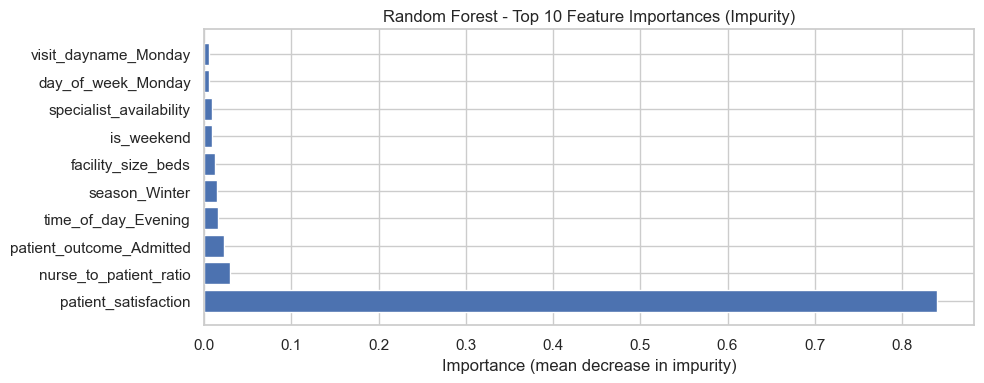

In [46]:
# Impuritty-based feature importance

model = rf_pipeline.named_steps['model']
importances = model.feature_importances_
assert len(importances) == len(all_features), "feature/importances length mismatch"

fi_df = pd.DataFrame({'feature': all_features, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)


fi_df.to_csv('rf_feature_importances_impurity.csv', index=False)

# Plot top 10
top_n = 10
top = fi_df.head(top_n).sort_values('importance')
plt.figure(figsize=(10, max(4, top_n*0.25)))
plt.barh(top['feature'], top['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance (mean decrease in impurity)')
plt.title('Random Forest - Top 10 Feature Importances (Impurity)')
plt.tight_layout()
plt.savefig('rf_feature_importances_impurity_top10.png', dpi=200, bbox_inches='tight')
plt.show()



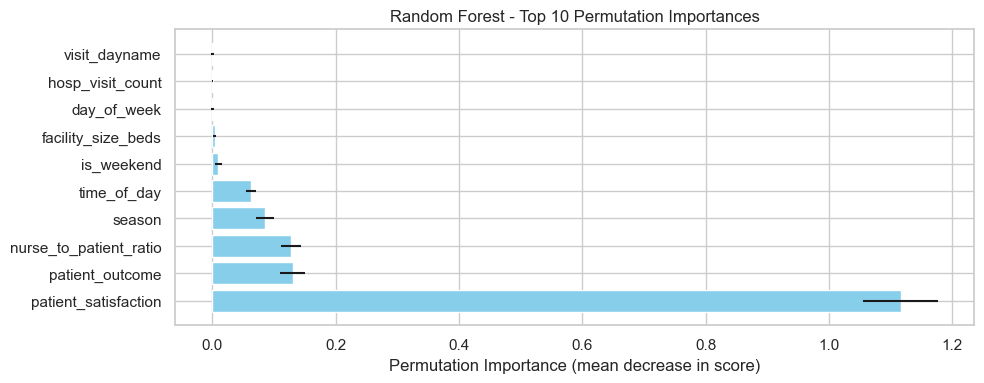

In [47]:
# Permutation-based feature importance
from sklearn.inspection import permutation_importance


# Use original features (numeric + categorical) BEFORE one-hot encoding
feature_names = numeric_cols + categorical_cols  # matches X_test columns

# Run permutation importance on the pipeline
perm = permutation_importance(
    rf_pipeline,      # pipeline: preprocessor + Random Forest
    X_test, 
    y_test,
    n_repeats=15,     # number of permutation runs
    random_state=42,
    n_jobs=-1
)

# Convert results to DataFrame
perm_df = pd.DataFrame({
    'feature': feature_names,
    'perm_mean': perm.importances_mean,
    'perm_std': perm.importances_std
}).sort_values('perm_mean', ascending=False).reset_index(drop=True)

# Save CSV for Power BI / portfolio
perm_df.to_csv('rf_feature_importances_permutation.csv', index=False)

# Plot top 5 features
top_n = 10
top = perm_df.head(top_n).sort_values('perm_mean')

plt.figure(figsize=(10, max(4, top_n*0.25)))
plt.barh(top['feature'], top['perm_mean'], xerr=top['perm_std'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Random Forest - Top 10 Permutation Importances')
plt.tight_layout()
plt.savefig('rf_feature_importances_perm_top10.png', dpi=200, bbox_inches='tight')
plt.show()


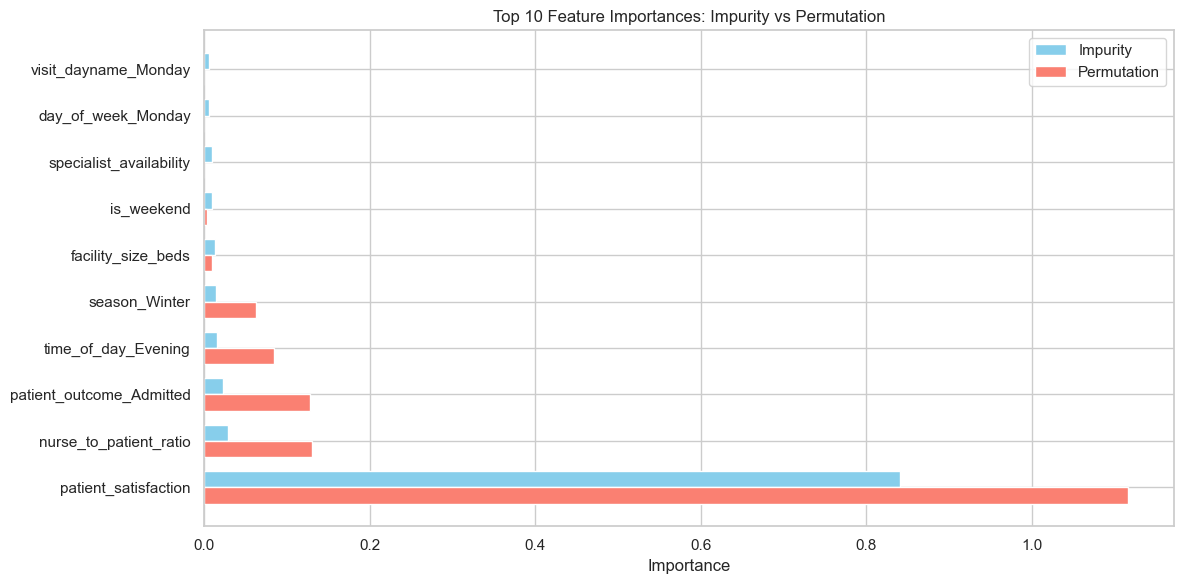

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Select top 10 from each
top_n = 10
top_impurity = fi_df.head(top_n).sort_values('importance')
top_perm = perm_df.head(top_n).sort_values('perm_mean')

# Make a combined plot
features = top_impurity['feature'].values  # Using impurity top 10 as reference
x = np.arange(len(features))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars side by side
bar_width = 0.35
ax.barh(x - bar_width/2, top_impurity['importance'], bar_width, label='Impurity', color='skyblue')
ax.barh(x + bar_width/2, top_perm['perm_mean'], bar_width, label='Permutation', color='salmon')

ax.set_yticks(x)
ax.set_yticklabels(features)
ax.invert_yaxis()  # Largest on top
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importances: Impurity vs Permutation')
ax.legend()
plt.tight_layout()
plt.show()


In [49]:
# attach predictions to test_df — ensure test_df exists as earlier
results_df = test_df.copy()
results_df = results_df.reset_index(drop=True)
results_df['predicted_wait_minutes'] = rf_preds
results_df['residual'] = results_df['total_wait_time_minutes'] - results_df['predicted_wait_minutes']

# Save full predictions CSV (for Power BI)
results_df.to_csv('er_wait_predictions_detailed.csv', index=False)
print("Saved er_wait_predictions_detailed.csv with", len(results_df), "rows")


Saved er_wait_predictions_detailed.csv with 1000 rows


In [50]:
# By hospital
agg_hosp = results_df.groupby('hospital_id').agg(
    actual_mean=('total_wait_time_minutes','mean'),
    predicted_mean=('predicted_wait_minutes','mean'),
    mae=('residual', lambda x: x.abs().mean()),
    count=('visit_id','count')
).reset_index()
agg_hosp.to_csv('er_wait_by_hospital.csv', index=False)

# By hour of day (use visit_hour column)
agg_hour = results_df.groupby('visit_hour').agg(
    actual_mean=('total_wait_time_minutes','mean'),
    predicted_mean=('predicted_wait_minutes','mean'),
    mae=('residual', lambda x: x.abs().mean()),
    count=('visit_id','count')
).reset_index().sort_values('visit_hour')
agg_hour.to_csv('er_wait_by_hour.csv', index=False)

# By urgency level
agg_urg = results_df.groupby('urgency_level').agg(
    actual_mean=('total_wait_time_minutes','mean'),
    predicted_mean=('predicted_wait_minutes','mean'),
    mae=('residual', lambda x: x.abs().mean()),
    count=('visit_id','count')
).reset_index().sort_values('urgency_level')
agg_urg.to_csv('er_wait_by_urgency.csv', index=False)

print("Saved summary CSVs: er_wait_by_hospital.csv, er_wait_by_hour.csv, er_wait_by_urgency.csv")



Saved summary CSVs: er_wait_by_hospital.csv, er_wait_by_hour.csv, er_wait_by_urgency.csv


In [51]:
# Save the trained Random Forest pipeline using joblib
import joblib
joblib.dump(rf_pipeline, 'rf_pipeline_joblib.pkl')
print("Saved rf_pipeline_joblib.pkl")


Saved rf_pipeline_joblib.pkl


In [52]:
# Compare top features from both methods (impurity vs permutation)
fi_top5 = fi_df.head(5)['feature'].tolist()
perm_top5 = perm_df.head(5)['feature'].tolist()

print("Top 5 features (model-based):", fi_top5)
print("Top 5 features (permutation):", perm_top5)

# Check overlap
common_features = set(fi_top5).intersection(set(perm_top5))
print("\nCommon Top Features:", list(common_features))

Top 5 features (model-based): ['patient_satisfaction', 'nurse_to_patient_ratio', 'patient_outcome_Admitted', 'time_of_day_Evening', 'season_Winter']
Top 5 features (permutation): ['patient_satisfaction', 'patient_outcome', 'nurse_to_patient_ratio', 'season', 'time_of_day']

Common Top Features: ['nurse_to_patient_ratio', 'patient_satisfaction']


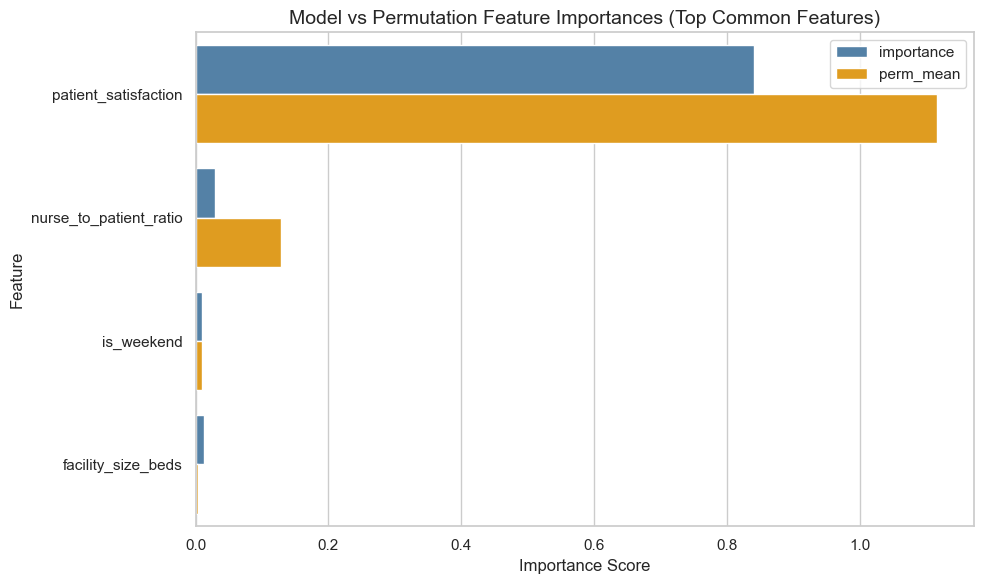

In [53]:
# Merge the top features from both DataFrames
fi_top = fi_df[['feature', 'importance']].head(10)
perm_top = perm_df[['feature', 'perm_mean']].head(10)

# Merge on the feature column (inner join keeps common features)
merged = pd.merge(fi_top, perm_top, on='feature', how='inner')

# Melt the dataframe for easier plotting in Seaborn
melted = merged.melt(id_vars='feature', 
                     value_vars=['importance', 'perm_mean'],
                     var_name='Type', value_name='Score')

# Sort by the average of both importances (so bars look organized)
melted['avg'] = melted.groupby('feature')['Score'].transform('mean')
melted = melted.sort_values('avg', ascending=False)

# Plot side-by-side bars
plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='Score', y='feature', hue='Type', palette=['steelblue', 'orange'])
plt.title('Model vs Permutation Feature Importances (Top Common Features)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.legend(title='')
plt.tight_layout()
plt.show()

In [54]:
# Actionable features
print("\nActionable Features (examples to focus insights on):")
actionable = ['nurse_to_patient_ratio', 'hosp_visit_count', 'is_weekend', 'visit_hour', 
              'facility_size_beds', 'prior_visits']
for feat in actionable:
    if feat in results_df.columns:
        print(" -", feat)


Actionable Features (examples to focus insights on):
 - nurse_to_patient_ratio
 - hosp_visit_count
 - is_weekend
 - visit_hour
 - facility_size_beds
 - prior_visits


In [55]:
# Display which hospitals or hours have the highest mean absolute error (MAE)
print("\nTop Hospitals by MAE:")
display(agg_hosp.sort_values('mae', ascending=False).head(10))

print("\nTop Hours by MAE:")
display(agg_hour.sort_values('mae', ascending=False).head(10))




Top Hospitals by MAE:


,hospital_id,actual_mean,predicted_mean,mae,count
1,HOSP-2,90.267677,90.035781,15.731863,198
3,HOSP-4,78.469945,79.649947,13.507429,183
0,HOSP-1,80.100000,81.768704,12.937892,220
2,HOSP-3,83.117949,86.379778,12.736819,195
4,HOSP-5,73.593137,74.731368,12.072721,204



Top Hours by MAE:


,visit_hour,actual_mean,predicted_mean,mae,count
17,17,100.586207,112.904007,24.375351,29
9,9,98.000000,96.043885,18.501284,35
8,8,92.648649,92.744207,16.238545,37
18,18,75.217391,81.417449,16.131646,46
19,19,82.312500,83.201891,15.842453,48
21,21,93.214286,96.830615,15.474470,42
1,1,73.893617,74.267793,15.165877,47
6,6,96.428571,93.154606,14.382632,42
23,23,87.026316,89.918893,14.249471,38
13,13,79.648649,84.234246,14.176608,37


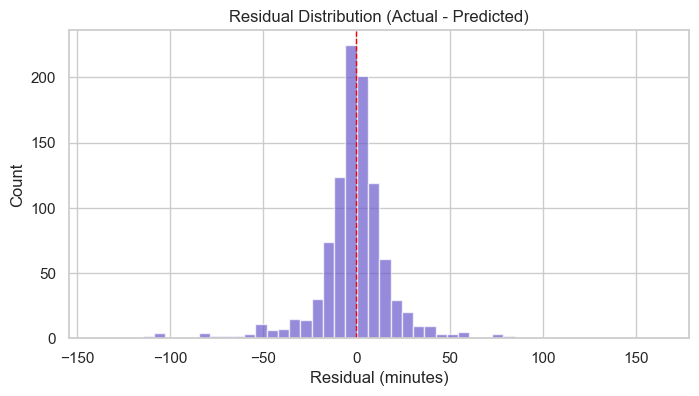

In [56]:
# Visualize residual distribution
plt.figure(figsize=(8,4))
plt.hist(results_df['residual'], bins=50, color='slateblue', alpha=0.7)
plt.title('Residual Distribution (Actual - Predicted)')
plt.xlabel('Residual (minutes)')
plt.ylabel('Count')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.show()

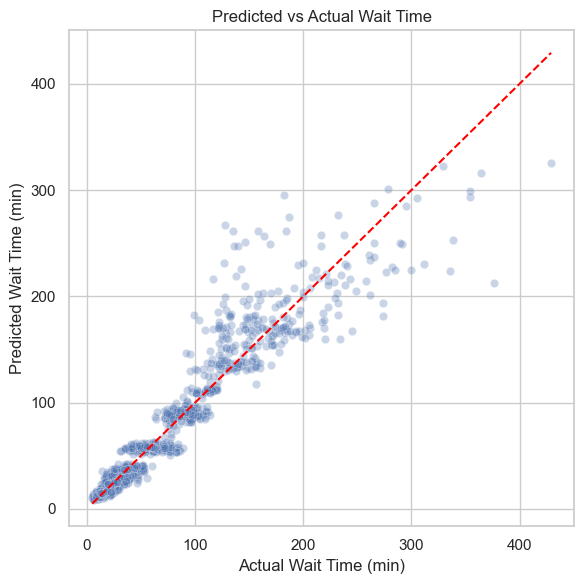

In [57]:
# Predicted vs Actual scatter plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=results_df['total_wait_time_minutes'], 
                y=results_df['predicted_wait_minutes'], alpha=0.3)
plt.plot([results_df['total_wait_time_minutes'].min(), results_df['total_wait_time_minutes'].max()],
         [results_df['total_wait_time_minutes'].min(), results_df['total_wait_time_minutes'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Wait Time (min)')
plt.ylabel('Predicted Wait Time (min)')
plt.title('Predicted vs Actual Wait Time')
plt.tight_layout()
plt.show()

In [58]:
# Overall MAE
mae_overall = results_df['residual'].abs().mean()
print(f"\nOverall Mean Absolute Error (MAE): {mae_overall:.2f} minutes")

print("\nInterpretation Tips:")
print("- If residuals are mostly centered around 0, your model generalizes well.")
print("- If some hospitals or hours show higher MAE, those are areas to prioritize for improvement.")
print("- Common top features across FI and Permutation Importance → more confidence in model interpretability.")
print("- Focus insights on actionable features like staffing, scheduling, and triage timing.")


Overall Mean Absolute Error (MAE): 13.38 minutes

Interpretation Tips:
- If residuals are mostly centered around 0, your model generalizes well.
- If some hospitals or hours show higher MAE, those are areas to prioritize for improvement.
- Common top features across FI and Permutation Importance → more confidence in model interpretability.
- Focus insights on actionable features like staffing, scheduling, and triage timing.


In [59]:
# List CSVs
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
print("CSV files:", csv_files)

# List PNGs
png_files = [f for f in os.listdir() if f.endswith('.png')]
print("PNG files:", png_files)



CSV files: ['er_wait_by_hospital.csv', 'er_wait_by_hour.csv', 'er_wait_by_urgency.csv', 'er_wait_predictions_detailed.csv', 'rf_feature_importances_impurity.csv', 'rf_feature_importances_permutation.csv']
PNG files: ['rf_feature_importances_impurity_top10.png', 'rf_feature_importances_impurity_top20.png', 'rf_feature_importances_perm_top10.png', 'rf_feature_importances_perm_top20.png']
